
<h1 style="font-size":40px>Value at Risk with Merton Jump-Diffusion Model(Single Asset)</h1>


<h2 style = "font-size:25px"><ins>THEORY</ins></h2> 

<p>The Merton jump-diffusion model predicts the price movements of an asset via a Stochastic Differential Equation(SDE)<a href="#ref1"><sup>[1]</sup></a>:


<a id="eq-merton"></a>
$$
\begin{equation}
d S_t = \mu S_t dt + \sigma S_t dW_t + S_t(J-1)dN_t \tag{1}
\end{equation}
$$

  
The first term captures a deterministic, linear change in asset price. The second term adds a continuous, fluctuating component, modeled by a Wiener process: 
    $$
    dW_t = \mathcal{N}(0,d t)= \sqrt{d t} \mathcal{N}(0,1)    
    $$
The final term represents a discontinuous jump, characterized by a frequency(encoded in $dN_t$) and a magnitude($J$). Merton assumes that $J$ is lognormally distributed:
    $$
    \text{ln}(J) \sim \mathcal{N}(\mu_J,\sigma^2_J)
    $$
whereas $dN_t$ is a Poisson process of intensity $\lambda$. Over a small interval $dt$, its probability of being zero is $e^{-\lambda dt}$:

   $$dN_t  \sim \begin{cases} 
          0 & p = e^{-\lambda dt} \\
          1 & 1-p 
       \end{cases}
    $$
    
We now introduce the coordinate $y_t = \text{ln}(S_t)$, and transform the above SDE accordingly. For the first two terms, we obtain the following
$$
dy_t =  \frac{\partial y_t}{\partial S}{dS} + \frac{\partial^2 y_t}{\partial S^2}{d S^2} 
$$ 
by applying a second order Taylor expansion and setting $\partial_t y_t = 0$. Thereafter, noting that $d W_t \sim\mathcal{O}(\sqrt{dt})$ and neglecting all powers of $dt$ greater than 1 leads to Itô's lemma:

$$
\begin{equation*}
d y_t = \left( \mu - \frac{\sigma^2}{2}\right) dt + \sigma dW_t 
\end{equation*}
$$
To account for the jump term, we can directly transform its induced differential $dS$ in the new coordinate, which works out to $[\ln(J S_t) - \ln(S_t)]dN_t$. Putting everything together yields

<a id="eq-merton-y"></a>
$$
\begin{equation}
d y_t = \left( \mu - \frac{\sigma^2}{2}\right) dt + \sigma dW_t + \ln(J) dN_t\tag{2}
\end{equation}
$$
While this equation can be analytically integrated over time, we will solve it numerically. The discretized version of <a href="#eq-merton-y">(2)</a> reads
$$
y_{t+ \Delta t} = y_t + \left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \mathcal{N}(0,\sqrt{\Delta t}) + N_{\Delta t} \mathcal{N}(\mu_J,\sigma^2)
$$
where $N_{\Delta t}$ is the discrete version of $dN_t$ defined above.
I chose to work with $S_t$ itself, so I write

<a id="eq-merton-final"></a>
$$
\begin{equation}
S_{t+\Delta t} = S_t e^{\left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma  \mathcal{N}(0,\sqrt{\Delta t}) + N_{\Delta t} \mathcal{N}(\mu_J,\sigma^2)} \tag{3}
\end{equation}
$$



<h2 style= "font-size":25px><ins>CODE</ins></h2>
To implement this model on Python, we first import a few modules. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import time as time

The function below calculates the Value at Risk via Monte Carlo simulations for single stock. Historical returns data is used to obtain the initial stock price, as well as values for the mean $(\mu$) and volatility($\sigma$). These can then plugged into equation <a href="#eq-merton-final">(3)</a> to calculate the evolution of the stock price as per the Merton jump-diffusion model. The price is sequentially calculated for a time horizon of N_days(days), and the simulation is repeated n_runs times.  The Value at Risk for is returned at a given confidence level.

In [2]:
def VaR_Monte_Carlo(S0,n_runs,returns,confidence_level):
    N_days = len(returns)
    Δt = 1/252                          #time step (in years) 
    μ = np.mean(returns)                #portfolio mean
    σ = np.std(returns)                 #portfolio std. dev.
    λ= 0.1                              #expected jumps per year
    μ_J = -0.02                         #mean jump size 
    σ_J = 0.05                          #jump size volatility
    S = np.zeros((n_runs, N_days))
    S[:, 0] = S0

    for i in range(n_runs):
        for j in range(1, N_days):
            dW = np.random.normal(0, np.sqrt(Δt))                       #Brownian term
            diffusion = (μ - 0.5 * σ **2) * Δt + σ * dW
            jump = np.random.poisson(λ*Δt)*np.random.normal(μ_J, σ_J)   #jump term
            S[i, j] = S[i, j - 1] * np.exp(diffusion + jump)
            
    simulated_returns = (S[:, -1] / S[:, 0]) - 1                        #final return for each run
    VaR_Merton = np.percentile(simulated_returns, 100*(1-confidence_level))  
    print(f"VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*VaR_Merton:.2f}%")
    
    return VaR_Merton

It helps to also calculate the VaR without the random jumps, so as to obtain a reference for the magnitude of jumps. Dropping the jump terms from <a href="#eq-merton-final">(3)</a> results in the Black-Scholes model, which we will also simulate and calculate the VaR for. Since the calculations can take up significant time and memory, we shall parallelize them using Python's $\texttt{multiprocessing}$ module by splitting up the above function as follows:

In [3]:
def simulate_path(params,seed):
    S0,N_days, Δt, μ, σ, λ, μ_J, σ_J = params
    np.random.seed(seed)         #ensures different random numbers for each run
    s_M = np.zeros(N_days)       #stores data for one run
    s_BS = np.zeros(N_days)
    s_M[0] = S0
    s_BS[0] = S0 
    for j in range(1, N_days):
        dW = np.random.normal(0, np.sqrt(Δt))  #Brownian term
        diffusion = (μ - 0.5 * σ ** 2) * Δt + σ * dW
        jump = np.random.poisson(λ * Δt) * np.random.normal(μ_J, σ_J)  #jump term
        s_M[j] = s_M[j - 1] * np.exp(diffusion + jump)
        s_BS[j] = s_BS[j - 1] * np.exp(diffusion)
    return_m = (s_M[-1]/s_M[0]) - 1
    return_bs = (s_BS[-1]/s_BS[0]) -1
    
    return return_m,return_bs

def VaR_Monte_Carlo(returns,S0,n_runs,confidence_level):
    N_days = len(returns)
    Δt = 1/251                          #time step (in years) 
    μ = np.mean(returns)                #historical mean
    σ = np.std(returns)                 #historical std. dev.
    λ= 0.1                              #expected jumps per year
    μ_J = -0.02                         #mean jump size 
    σ_J = 0.05                          #jump size volatility
                     
    params = S0,N_days, Δt, μ, σ, λ, μ_J, σ_J
    #use multiprocessing to parallelize the simulations
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(simulate_path,[(params, seed) for seed in range(n_runs)])
    R_M, R_BS = zip(*results)
    
    R_M = np.array(R_M)  
    R_BS = np.array(R_BS)

    VaR_Merton = np.percentile(R_M, 100*(1-confidence_level))  

    VaR_BS = np.percentile(R_BS, 100*(1-confidence_level))   

    return VaR_Merton,VaR_BS

This approach works well for very large number of runs even on a laptop, where memory constraints might have prevented the code from executing had we used the initial function or even a vectorized version of it. Note that each run has its own random seed, but the set of seeds is fixed, allowing for reproducable results. Once the VaR is calculated, the function below visualizes it against a histogram of the input(historical) data. 

In [4]:
def plot_returns(portfolio_returns,confidence_level,varM,varBS):
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(portfolio_returns, bins=50, color="black", alpha=0.6, label="Returns")
    #show VaR
    ax.axvline(varM, color='blue', linestyle='dashed', linewidth=2, label=f'VaR_Merton $({varM:.4f})$')
    ax.axvline(varBS, color='red', linestyle='dashed', linewidth=2, label=f'VaR_Black-Scholes $({varBS:.4f})$')

    ax.set_title(r"Histogram of Historic Portfolio Returns with VaR at ${}\%$ Confidence".format(confidence_level*100))
    ax.set_xlabel("Returns")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

The main function below collects the historical data of a stock and executes Monte Carlo simulations of stock price using Merton's model. 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


VaR at 95.0%(Merton Jump-Diffusion): -3.49%
VaR at 95.0%(Black-Scholes): -2.67%


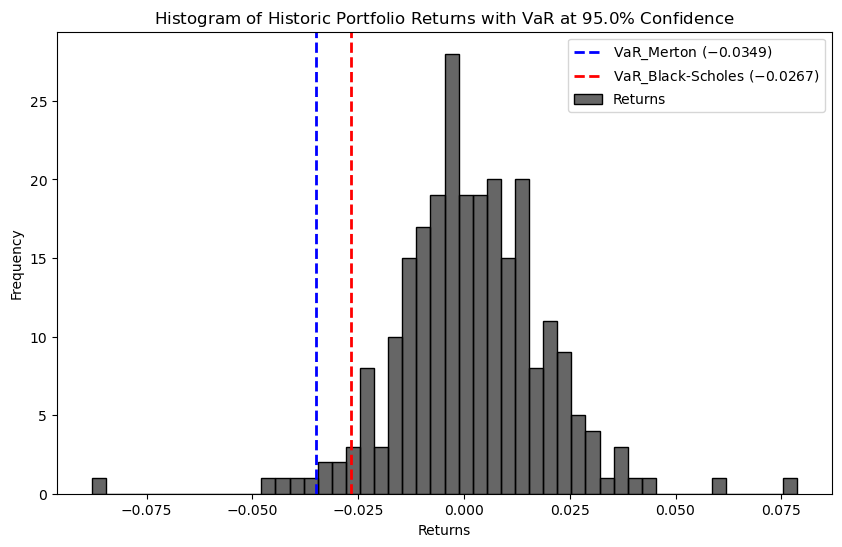

In [5]:
if __name__=="__main__":
    t1 = time.time()
    ticker = "AMZN"                            #choose portfolio of stocks
    confidence_level= 0.95                     #set confidence level for VaR
    
    start =pd.Timestamp(2024,2,1)
    stop = pd.Timestamp(2025,2,1)
    
    data = yf.download(ticker, start, stop)    #download data
    
    close_prices = data["Close"]
    S0 = close_prices.iloc[0,0]                #initial stock price
    returns = close_prices.pct_change().dropna()
    returns = returns[ticker].to_numpy()
    n_runs = 10000                             #number of Monte Carlo runs
    
    VaR_Merton,VaR_BS = VaR_Monte_Carlo(returns,S0,n_runs,confidence_level) 
    print(f"VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*VaR_Merton:.2f}%")
    print(f"VaR at {confidence_level*100}%(Black-Scholes): {100*VaR_BS:.2f}%")   
    
    
    plot_returns(returns,confidence_level, VaR_Merton,VaR_BS)


We notice a clear difference($\Delta)$ between the VaR obtained from the Merton model and the Black-Scholes one. Raising $\lambda$ further will only widen the gap, and it's a good exercise to verify that $\Delta \to 0 $ as $\lambda \to 0$.

## References

<a id="ref1"></a>[1] Matsuda, Kazuhisa. "<a href="https://maxmatsuda.com/Papers/Intro/Intro%20to%20MJD%20Matsuda.pdf">*Introduction to Merton jump diffusion model*</a>" Department of Economics, The Graduate Center, The City University of New York, New York (2004).